# Analise de ações com algoritmos de forecast

### instala dependecias

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 36.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Importa dependecias

In [2]:
import pandas as pd
import yfinance as yf
import datetime 
import numpy as np
from datetime import timedelta
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '${:,.2f}'.format


## Seleciona o código da ação e periodo

In [3]:
tickers = 'ARZZ3.SA'
start_date = datetime.datetime.now().date() + datetime.timedelta(days=-4000)
end_date = datetime.datetime.now().date() 

## Faz o download do dataframe com as informações

In [4]:
df_ticket = yf.download(tickers,start_date,end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
df_ticket.reset_index(inplace=True)

## Analise do dataframe

In [6]:
#print(df_ticket.isnull().sum())
#print(df_ticket.loc[df_ticket['Adj Close']==0])
print(df_ticket.describe)


<bound method NDFrame.describe of            Date   Open   High    Low  Close  Adj Close    Volume
0    2011-02-02 $20.50 $22.00 $20.26 $21.25     $16.87  14606400
1    2011-02-03 $21.10 $21.10 $20.62 $21.05     $16.71   1766100
2    2011-02-04 $20.99 $21.28 $20.90 $21.00     $16.67    873400
3    2011-02-07 $21.00 $21.44 $20.90 $21.00     $16.67    396100
4    2011-02-08 $20.72 $21.10 $20.08 $20.08     $15.94      3933
...         ...    ...    ...    ...    ...        ...       ...
2666 2021-11-23 $73.23 $73.28 $69.56 $71.07     $71.07   1106100
2667 2021-11-24 $70.93 $71.88 $69.65 $71.30     $71.30    903500
2668 2021-11-25 $71.31 $72.78 $70.43 $71.81     $71.81    720900
2669 2021-11-26 $69.46 $69.59 $67.98 $69.14     $69.14    697900
2670 2021-11-29 $69.97 $70.00 $67.87 $68.20     $68.20   1033000

[2671 rows x 7 columns]>


## Ajuste tipo da Data

In [7]:
df_ticket.Date = pd.to_datetime(df_ticket.Date)

In [8]:
df_ticket = df_ticket.set_index(df_ticket['Date']).sort_index()
df_ticket.drop("Date", axis=1, inplace=True)

## Visualiza gráfico

In [9]:
df_ticket.info
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ticket.index, y=df_ticket['Close']))


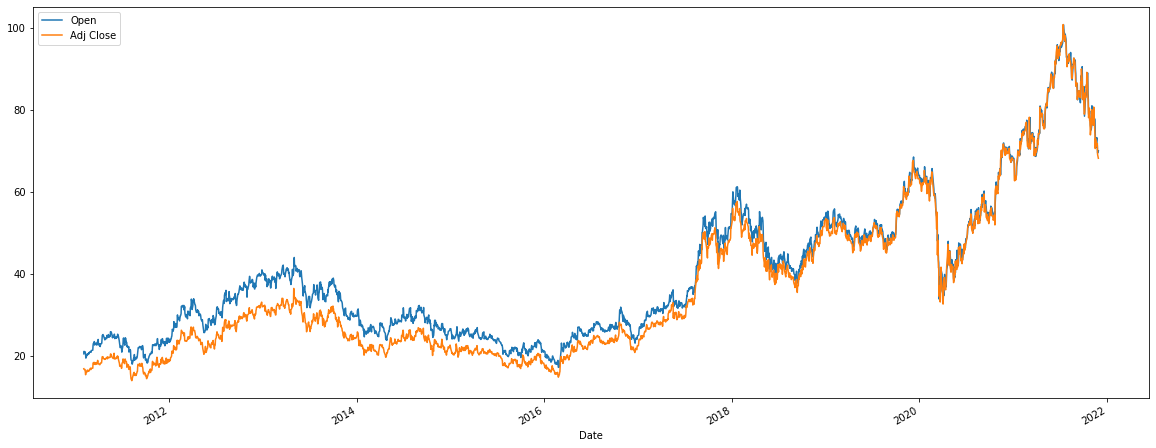

In [10]:
ts = df_ticket[['Open','Adj Close']]
ts.plot(figsize=(20,8))

## Media Móvel

In [11]:
df_ticket['MediaMovel10Dias'] = df_ticket["Adj Close"].rolling(window=10).mean()
df_ticket['MediaMovel30Dias'] = df_ticket["Adj Close"].rolling(window=30).mean()
df_ticket['MediaMovel150Dias'] = df_ticket["Adj Close"].rolling(window=150).mean()
df_ticket['MediaMovel365Dias'] = df_ticket["Adj Close"].rolling(window=365).mean()

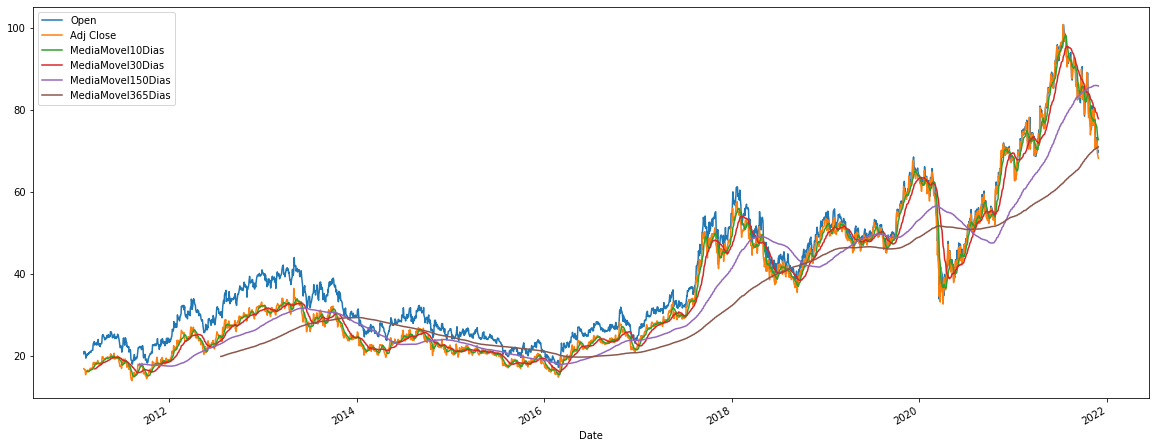

In [12]:
ts = df_ticket[['Open','Adj Close','MediaMovel10Dias','MediaMovel30Dias','MediaMovel150Dias','MediaMovel365Dias']]

ts.plot(figsize=(20,8))

# Forecast

## Prophet 

https://facebook.github.io/prophet/docs/quick_start.html

### configura a base de treino do modelo

In [13]:
#Vamos separar a base no periodo de teste e treino

# Inicalmente vamos treinar o modelo de 05/1997 a 05/2019
start_train = "2011-05-14"
end_train = "2021-11-24"

#Vamos testar o modelo de 05/2019 a 06/2020
start_test = "2019-06-01"
end_test = "2020-06-05"

df_train = df_ticket[start_train : end_train]
df_test = df_ticket[start_test : end_test]

print('Train Dataset:',df_train.shape)
print('Test Dataset:',df_test.shape)
print(df_train.head())


Train Dataset: (2599, 10)
Test Dataset: (251, 10)
             Open   High  ...  MediaMovel150Dias  MediaMovel365Dias
Date                      ...                                      
2011-05-16 $24.75 $24.75  ...               $nan               $nan
2011-05-17 $25.90 $25.90  ...               $nan               $nan
2011-05-18 $25.75 $25.87  ...               $nan               $nan
2011-05-19 $25.80 $26.25  ...               $nan               $nan
2011-05-20 $25.78 $26.00  ...               $nan               $nan

[5 rows x 10 columns]


In [14]:
df_test = df_ticket

#Transformando o Dataframe de teste correto para o Prophet
#Precisamos que a data volte a ser uma coluna
df_test = df_test.reset_index() 

#Excluindo as colunas que não vamos precisar
df_test.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace = True) 

#Renomeando as colunas para o padrão do prophet
df_test.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True) 
df_test.head()

,ds,y,MediaMovel10Dias,MediaMovel30Dias,MediaMovel150Dias,MediaMovel365Dias
0,2011-02-02,$21.25,$nan,$nan,$nan,$nan
1,2011-02-03,$21.05,$nan,$nan,$nan,$nan
2,2011-02-04,$21.00,$nan,$nan,$nan,$nan
3,2011-02-07,$21.00,$nan,$nan,$nan,$nan
4,2011-02-08,$20.08,$nan,$nan,$nan,$nan


### executo script de treino do modelo

In [15]:
#Transformando o dataset de treinamento correto para o Prophet

df_train = df_train.reset_index()

df_train.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace = True)

df_train.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

df_train.head()

,ds,y,MediaMovel10Dias,MediaMovel30Dias,MediaMovel150Dias,MediaMovel365Dias
0,2011-05-16,$24.75,$19.56,$19.09,$nan,$nan
1,2011-05-17,$25.75,$19.65,$19.17,$nan,$nan
2,2011-05-18,$25.80,$19.75,$19.25,$nan,$nan
3,2011-05-19,$25.40,$19.84,$19.33,$nan,$nan
4,2011-05-20,$25.50,$19.89,$19.41,$nan,$nan


In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test['ds'], y=df_test['y']))


### Aplica o modelo

In [17]:
model = Prophet(growth ="linear",
                seasonality_mode = 'multiplicative',
                daily_seasonality = False)
model.fit(df_train)

In [18]:
# determinar o período de dias para previsão
future_prices = model.make_future_dataframe(periods=365)

#Excluindo os finais de semana da  predição
future = future_prices[future_prices['ds'].dt.dayofweek < 5]

# realizar a previsão para o período estabelecido
forecast = model.predict(future)

No Dataframe resultante da predição do Modelo do Prohet há 4 colunas, além da Data, são elas:

yhat = valor predito

yhat_lower = Menor valor predito

yhat_upper = Maior valor predito

e sem mais delongas, vamos visualizar o gráfico da previsão.

### Analise do resultado

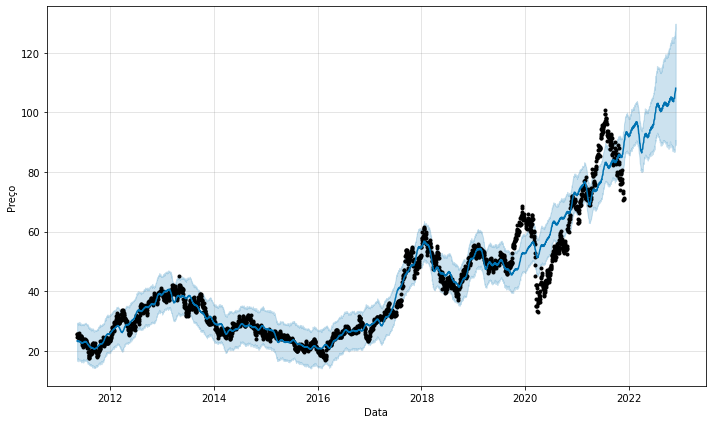

In [19]:
# É possivel plotar um grafico direto da biblioteca prophet
model.plot(forecast, xlabel='Data', ylabel='Preço');

In [20]:
plot_plotly(model,forecast)

## Average forecasting

O average forecasting assume que os dados estão distribuídos em torno de uma média constante.
Rigorosamente, esse tipo de série temporal é chamada estacionária.

https://www.letscode.com.br/blog/python-para-financas-analise-de-series-temporais

### 

In [21]:
def treino_teste(dados):

    # Definir quantos porcento queremos pra treino
    pct_treino = 0.75


    # Definir o primeiro dia, o último e o total de dias nos nossos dados
    primeiro_dia = min(dados.index)
    ultimo_dia = max(dados.index)
    total_dias = (ultimo_dia - primeiro_dia).days

    
    # "Dias de treino, dias de glória" - Charlie Brown Jr
    dias_treino = np.ceil(total_dias * pct_treino)
    dias_teste = np.floor(total_dias * (1 - pct_treino))

    # Data em que o treino deve parar
    data_parada = primeiro_dia + timedelta(days=dias_treino)
    

    # Dividir o dataset usando a data de parada do treino
    dados_treino = dados[:data_parada] # do começo à data de parada
    dados_teste = dados[data_parada:] # da data de parada ao final

    return dados_treino, dados_teste, data_parada

In [22]:
def AF(X, y):
    # Criando lista com as médias
    y_hat_AF = []

    for i in range(len(y)):
        y_hat_AF.append(np.mean(X))

    # Transformando em Pandas Series
    y_hat_AF = pd.Series(y_hat_AF, index=y.index)
    
    return y_hat_AF

In [23]:
X_ticket, y_ticket, data_parada_ticket = treino_teste(df_ticket['Close'])    

In [24]:
y_hat_AF_ticket = AF(X_ticket, y_ticket)
df_average_forecasting = y_hat_AF_ticket

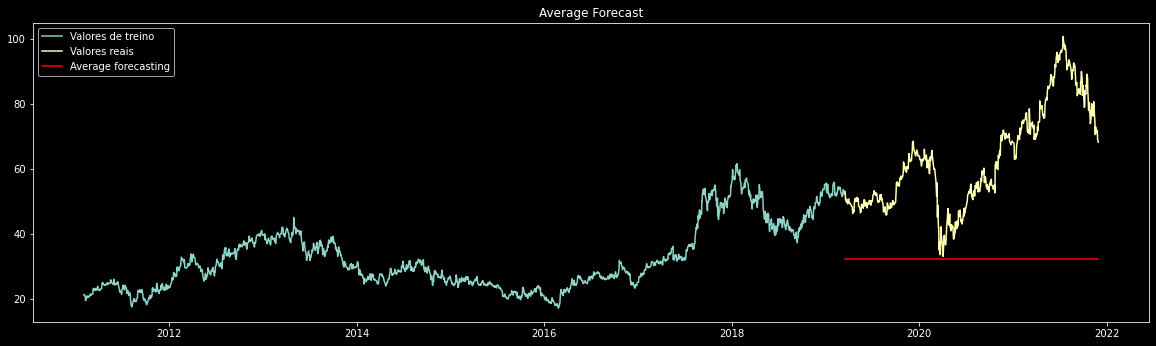

In [25]:
# Gerando gráfico com fundo escuro

with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 5.5))
    plt.title("Average Forecast")
  
    # Dados reais
    plt.plot(X_ticket, label='Valores de treino')
    plt.plot(y_ticket,label='Valores reais')

    

    # Predições
    plt.plot(y_hat_AF_ticket, label='Average forecasting', color='red')
    plt.legend()
    plt.show()

## Drift forecast

O drift forecast assume que os dados estão distribuídos em torno de uma média constante que aumenta ou diminui constantemente no tempo.

Rigorosamente, esse tipo de série temporal é dito com drift.

In [26]:
def DF(X, y):
    y_t = X[-1]
    m = (y_t - X[0]) / len(X)
    h = np.linspace(0,len(y.index)-1, len(y.index))

    # Criando lista com o resultado da fórmula
    y_hat_DF = []
    
    for i in range(len(y.index)):
        y_hat_DF.append(y_t + m * h[i])

    # Transformando em Pandas Series
    y_hat_DF = pd.Series(y_hat_DF, index=y.index)

    return y_hat_DF

In [27]:
X_drift_ticket, y_drift_ticket, data_parada_drift_ticket = treino_teste(df_ticket['Close'])

In [28]:
# Prevendo dados futuros com a função
y_hat_AF__drift_ticket = AF(X_drift_ticket, y_drift_ticket)

In [29]:
# Prevendo dados futuros com a função
y_hat_DF_drift_ticket = DF(X_drift_ticket, y_drift_ticket)

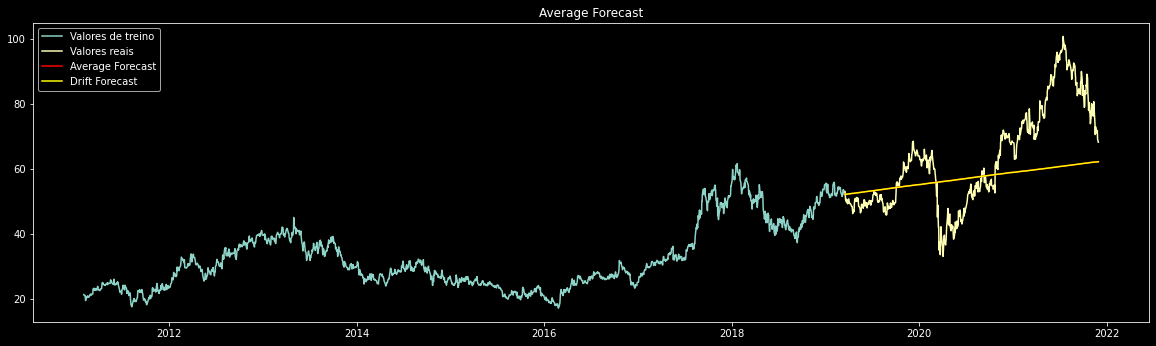

In [30]:
# Gerando gráfico com fundo escuro

with plt.style.context('dark_background'):
    plt.figure(figsize=(20, 5.5))
    plt.title("Average Forecast")

    # Dados reais
    plt.plot(X_drift_ticket, label='Valores de treino')
    plt.plot(y_drift_ticket, label='Valores reais')

    # Predições
    plt.plot(y_hat_DF_drift_ticket, label='Average Forecast', color='red')
    plt.plot(y_hat_DF_drift_ticket, label='Drift Forecast', color='Yellow')

    plt.legend()
    plt.show()

## Simple moving average

O simple moving average acompanha as médias se movendo ao longo do tempo.

In [31]:
def SMA(dados, day):
    y_hat_SMA = dados['Close'].rolling(window=day).mean()

    return y_hat_SMA

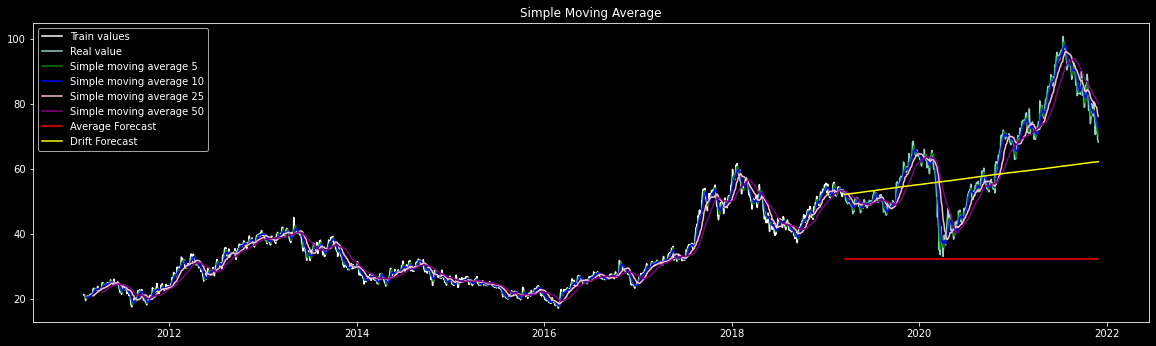

In [32]:
days = [5, 10, 25, 50]
colors = ['green', 'blue', 'pink', 'purple']

# Gerando gráfico com fundo escuro 
with plt.style.context('dark_background'):
    # Configurações básicas
    plt.figure(figsize=(20, 5.5))
    plt.title("Simple Moving Average")

    # Dados reais
    plt.plot(X_ticket, label='Train values', color='white')
    plt.plot(y_ticket, label='Real value')

    # Moving average
    for i, day in enumerate(days):
        y_hat_SMA_ticket = SMA(df_ticket, day)
        plt.plot(y_hat_SMA_ticket, label='Simple moving average '+str(day), color=colors[i])

    # Previsões anteriores        
    plt.plot(y_hat_AF_ticket, label='Average Forecast', color='red')
    plt.plot(y_hat_DF_drift_ticket, label='Drift Forecast', color='Yellow')


    # Configurações básicas
    plt.legend()
    plt.show()

## Cumulative moving average